# Beberapa Contoh Penerapan Neural Network

- Menggunakan bahasa pemrograman python
- Bisa menggunakan library **TensorFlow** atau **PyTorch**
- **TensorFlow** dan **PyTorch**: Python library untuk Machine Learning. Termasuk di dalamnya ada Neural Network (NN)
- [https://www.tensorflow.org/](https://www.tensorflow.org/)
- [https://pytorch.org/](https://pytorch.org/)

![](img/img7a.png)
![](img/img7b.png)

- Cara install library **TensorFlow**:

`pip install tensorflow`

- Cara install library **PyTorch** jika memiliki GPU

`pip3 install torch torchvision torchaudio`

- Cata install library **PyTorch** jika tidak memiliki GPU

`pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu`

## Contoh 1 - Fungsi Minimum

1. Untuk fungsi minimum, kita hanya membutuhkan `optimizer` dari **PyTorch**. Tidak sampai membuat NN.
2. Misalkan: optimalkan persamaan:

$$ f(x_1, x_2) = 3x_1^2 - 2x_1x_2 + 3x_2^2 - x_1 - x_2 - 3$$

3. Berapa nilai $x_1$ dan $x_2$ sehingga $y$ atau $f(x_1, x_2)$ paling minimum?

### Menentukan fitness function

In [1]:
def pers1(x):
    return 3*x[0]**2 - 2*x[0]*x[1] + 3*x[1]**2 - x[0] - x[1] - 3

### Menentukan fungsi optimizer

- Disini kita akan menggunakan `SGD` atau stochastic gradient descent optimizer.
- Optimizer selainnya dapat dilihat pada dokumentasi PyTorch di websitenya: [https://pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html)

In [9]:
import torch

def minimize(function, initial_parameters, iterations):
    list_params = []
    params = initial_parameters
    params.requires_grad_()
    optimizer = torch.optim.SGD([params], lr=0.1)

    for i in range(iterations):
        optimizer.zero_grad()
        loss = function(params)
        loss.backward()
        optimizer.step()
        list_params.append(params.detach().clone()) #here
        
    return params, list_params

### Jalankan **PyTorch**

- Kita bisa menentukan starting point sebagai titik awal pencarian

In [10]:
iterations = 20
starting_point = torch.tensor([-5.,5.])
minimized_params, list_of_params = minimize(pers1, starting_point, iterations)

### Plot hasilnya

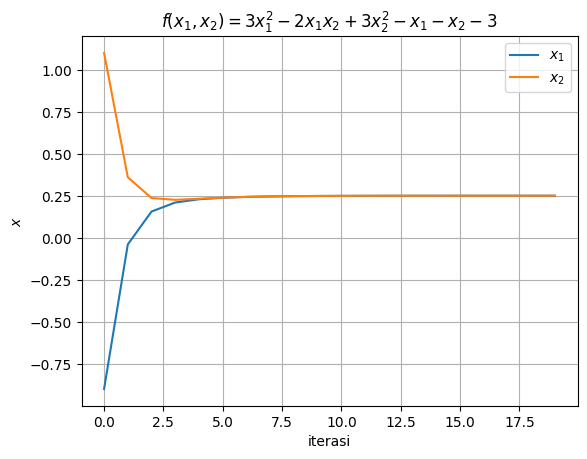

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(list_of_params, label=['$x_1$','$x_2$'])
ax.set_title('$ f(x_1, x_2) = 3x_1^2 - 2x_1x_2 + 3x_2^2 - x_1 - x_2 - 3 $')
ax.set_xlabel('iterasi')
ax.set_ylabel('$x$')
ax.legend()
ax.grid()

### Tampilkan hasilnya

In [13]:
print("nilai x_1 dan x_2 terbaik adalah {:.2f} dan {:.2f}".format(minimized_params[0], minimized_params[1]))

nilai x_1 dan x_2 terbaik adalah 0.25 dan 0.25


- Melakukan optimalisasi lebih sederhana dengan menggunakan PyTorch
- NN paling sesuai untuk menyelesaikan suatu permasalahan regresi dan klasifikasi

## Contoh 2 - Simple Regression Problem

- Misalkan diketahui ada sebanyak 100 data sebagai berikut:

Text(0.5, 1.0, 'Data')

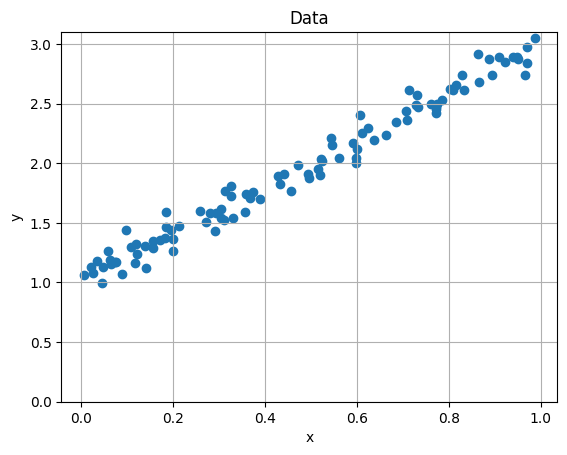

In [15]:
import numpy as np

true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (.1 * np.random.randn(N, 1))

fig, ax = plt.subplots()
    
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim([0, 3.1])
ax.grid()
ax.set_title('Data')


- Bagaimana persamaan regresi, yaitu hubungan antara nilai $x$ terhadap $y$ dari sekumpulan data di atas?
- Kita bisa mendapatkannya menggunakan PyTorch

### Splitting dataset

- Hal yang paling pertama kita lakukan adalah membagi data menjadi 2 bagian, yaitu data train dan data validation

In [16]:
idx = np.arange(N)
np.random.shuffle(idx)



In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

#### 2. Model Configuration

In [ ]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

In [ ]:
def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [ ]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to('cpu')

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))

#### 3. Model Training

In [ ]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

In [ ]:
# %load model_training/v5.py

# Defines number of epochs
n_epochs = 50

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch('cpu', train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch('cpu', val_loader, val_step_fn)
        val_losses.append(val_loss)


####  4. Plot hasilnya

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss', c='b')
plt.plot(val_losses, label='Validation Loss', c='r')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

#### 5. Tampilkan hasilnya

In [ ]:
print(model.state_dict())